# TF_Dataset_module_tutorial

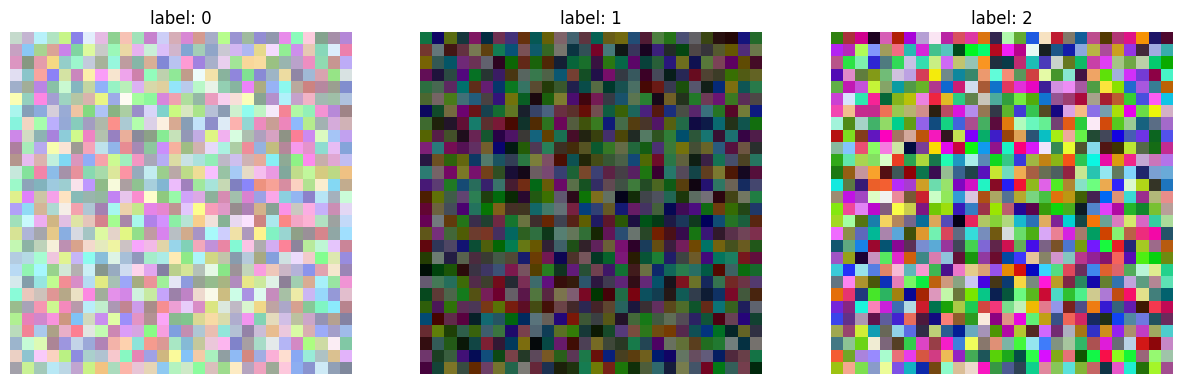

In [23]:
# 예제 데이터 생성
# 이미지 형태의 넘파이 배열로 해보자


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# 이전 CNN 튜토리얼의 예제를 가져옴
np.random.seed(0)

sample_size = 1000
sample_data_0 = np.random.uniform(0.5, 1.0, size=(sample_size, 28, 28, 3))
sample_data_1 = np.random.uniform(0.0, 0.5, size=(sample_size, 28, 28, 3))
sample_data_2 = np.random.uniform(0.0, 1.0, size=(sample_size, 28, 28, 3))

# 레이블 생성
labels_0 = np.full((sample_size,), 0, dtype=int)
labels_1 = np.full((sample_size,), 1, dtype=int)
labels_2 = np.full((sample_size,), 2, dtype=int)


# 데이터와 레이블 결합
data = np.concatenate((sample_data_0, sample_data_1, sample_data_2), axis=0)
labels = np.concatenate((labels_0, labels_1, labels_2), axis=0)

# tf.data.Dataset 생성
### from_tensor_slice((data, labels))
dataset = tf.data.Dataset.from_tensor_slices((data, labels))

###################################################################
# TF Dataset은 일반적인 리스트나 배열과 다르게 인덱싱을 직접 지원하지 않음 !!!
# 이터레이션을 이용하여 특정 인덱스에 있는 원소를 가져오거나 => 큰 데이터셋에서는 비효율
# skip, take 메서드를 이용
# take로 가져온 녀석은 tf.data.Dataset 객체
# .as_numpy_iterator().next() 로 Numpy iterator로 변환해야 함
# 아니면 직접 루프로 구현해야함 => for image, label in 객체 => 왜 이런건지는 모르겠음
###################################################################

# 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
samples_for_visualization = [
    dataset.skip(sample_size*i).take(1).as_numpy_iterator().next() for i in range(3)
    ]

for i in range(3):
  image, label = samples_for_visualization[i]
  axes[i].imshow(image)
  axes[i].set_title(f'label: {label}')
  axes[i].axis('off')

plt.show()

In [24]:
# 데이터셋 모델 입력 준비

# 데이터셋 셔플
dataset = dataset.shuffle(buffer_size=len(data))

# 트 발 테 분리
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# 배치 처리
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


# 셔플 => 분할 => 배치 처리가 제일 나이스한 수순인 것 같다
# 배치 처리하고 분할하면 문제 생기더라

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 576)              

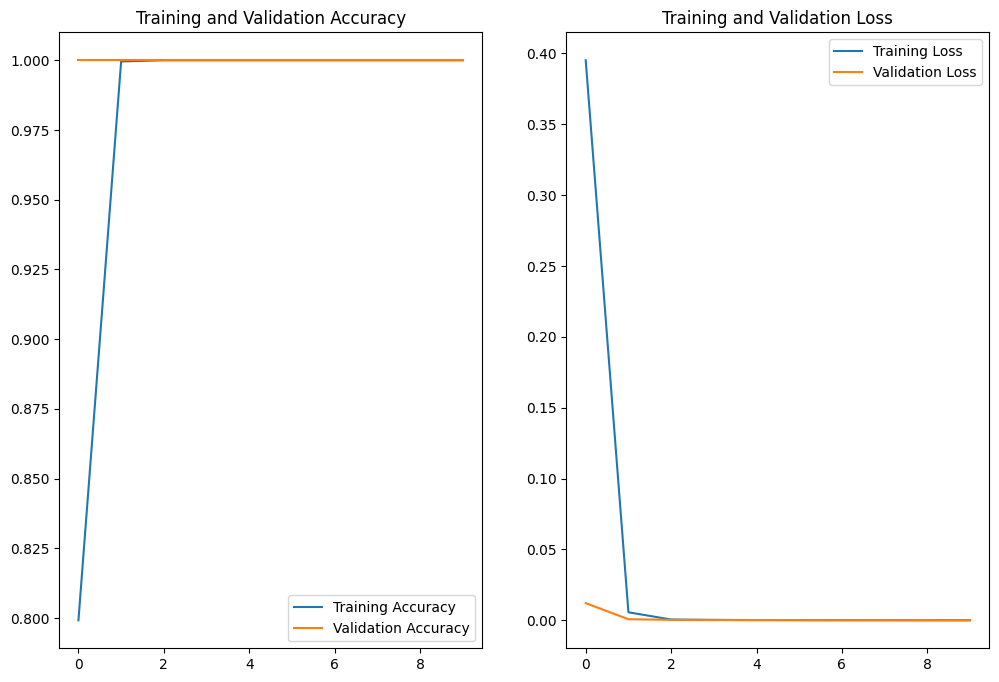

In [25]:
# 테스트 모델 생성
# 멀티 클래스 분류 => 막층 softmax, sparse categorical entropy

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# 테스트 데이터셋 평가
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

10/10 [==============================] - 0s 11ms/step - loss: 6.2783e-05 - accuracy: 1.0000
Test Loss: 6.278341606957838e-05
Test Accuracy: 1.0


# 완벽해 !